# BMW Price Prediction
In diesem Notebook bauen wir ein Modell, das den Preis eines BMW in CHF vorhersagt.  
Wir verwenden Daten von AutoScout24 sowie Konsumenten- und Teuerungs-Indizes,  
trainieren Random Forest und Lineare Regression, vergleichen die Modelle und  
deployen das beste Modell auf Huggingface.

## 1. Setup und Abhängigkeiten
Installiere und importiere alle benötigten Bibliotheken.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

## 2. Daten einlesen  
Wir laden den BMW-Datensatz sowie die Konsumenten- und CPI-Daten.

In [2]:
df_bmw = pd.read_csv("bmw_data.csv", encoding="utf-8")
df_kons = pd.read_csv("ks_q.csv", encoding="utf-8")
df_ts   = pd.read_csv("ts-x-03.04.03.02.01.csv", encoding="utf-8")

## 3. Datenbereinigung  
- Entfernen von "Neues Fahrzeug"  
- Entfernen fehlender Preise  
- Imputieren von PS & Kilometer  
- Nur gültige `MM.YYYY`-Einträge  
- Parsen der `Jahr`-Spalte

In [3]:
# 1. 'Neues Fahrzeug'-Einträge entfernen
df_bmw = df_bmw[df_bmw['Jahr'] != 'Neues Fahrzeug'].copy()

# 2. Nur gültige MM.YYYY–Einträge
mask = df_bmw['Jahr'].str.match(r'^\d{1,2}\.\d{4}$')
df_bmw = df_bmw[mask].copy()

# 3. Fehlende Preise entfernen
df_bmw = df_bmw.dropna(subset=['Preis'])

# 4. PS & Kilometer missing mit Median auffüllen
df_bmw['Kilometer'] = df_bmw['Kilometer'].fillna(df_bmw['Kilometer'].median())
df_bmw['PS']        = df_bmw['PS'].fillna(df_bmw['PS'].median())

# 5. 'Jahr' splitten und Datum erzeugen
df_bmw[['month_str','year_str']] = df_bmw['Jahr'].str.split('.', expand=True)
df_bmw['month'] = df_bmw['month_str'].astype(int)
df_bmw['year']  = df_bmw['year_str'].astype(int)
df_bmw['date']  = pd.to_datetime(df_bmw[['year','month']].assign(day=1))

## 3. Feature Engineering

- Alter in Tagen und Jahren seit Aufnahme
- Dummy-Kodierung Getriebe
- Gruppierung Top-10 Modelle + “Other”
- Löschen überflüssiger Spalten

In [4]:
# --- 4. Feature Engineering ---

# 4.1 Alter berechnen
today = pd.Timestamp('2025-05-24')
df_bmw['age_days']  = (today - df_bmw['date']).dt.days
df_bmw['age_years'] = df_bmw['age_days'] / 365.0

# 4.2 Getriebe dummykodieren (nur, wenn die Spalte noch existiert)
if 'Getriebe' in df_bmw.columns:
    df_bmw = pd.get_dummies(
        df_bmw, 
        columns=['Getriebe'], 
        prefix='gear', 
        drop_first=True
    )

# 4.3 Modell-Kürzel extrahieren und gruppieren (nur, wenn 'Model' noch da ist)
if 'Model' in df_bmw.columns:
    # Erstes Wort groß schreiben
    df_bmw['Model_main'] = (
        df_bmw['Model']
        .str.split()
        .str[0]
        .str.upper()
    )
    # Top-10 Kürzel
    top10_main = df_bmw['Model_main'] \
                    .value_counts() \
                    .nlargest(10) \
                    .index
    # Gruppieren
    df_bmw['Model_group'] = df_bmw['Model_main'].where(
        df_bmw['Model_main'].isin(top10_main),
        other='Other'
    )
    # Dummy-Variablen
    df_bmw = pd.get_dummies(
        df_bmw,
        columns=['Model_group'],
        drop_first=True
    )

# 4.4 Überflüssige Spalten löschen (fehlende werden ignoriert)
to_drop = ['Jahr','month_str','year_str','date','Model','Model_main']
df_bmw.drop(columns=to_drop, errors='ignore', inplace=True)

# Kontrolle: verbleibende Spalten
print("Spalten nach Feature Engineering:", df_bmw.columns.tolist())



Spalten nach Feature Engineering: ['Brand', 'Preis', 'Kilometer', 'PS', 'month', 'year', 'age_days', 'age_years', 'gear_Automatikgetriebe', 'gear_Schaltgetriebe', 'Model_group_M135I', 'Model_group_M3', 'Model_group_M4', 'Model_group_Other', 'Model_group_X1', 'Model_group_X3', 'Model_group_X4', 'Model_group_X5', 'Model_group_X6', 'Model_group_Z4']


## 4. Merge mit Konsumenten- und CPI-Daten

### 4.1 Quartals-Daten (ks_q.csv)

In [5]:
# Konsumenten-Index
df_kons['date'] = pd.to_datetime(df_kons['date'])
df_kons = df_kons[['date','value']].rename(columns={'value':'ks_index'})

# Quartalsanfang in df_bmw
df_bmw['date']    = pd.to_datetime(df_bmw[['year','month']].assign(day=1))
df_bmw['quarter'] = df_bmw['date'].dt.to_period('Q').dt.start_time

# Left-Merge
df_merged = df_bmw.merge(
    df_kons,
    left_on='quarter',
    right_on='date',
    how='left',
    suffixes=('','_kons')
).drop(columns=['date_kons'])


### 4.2 Jahres-Daten (CPI)

In [6]:
df_ts = df_ts[['YEAR','CPI']]
df_merged = df_merged.merge(
    df_ts,
    left_on='year',
    right_on='YEAR',
    how='left'
).drop(columns=['YEAR'])


### 4.3 Imputation fehlender Werte

In [7]:
med_ks  = df_merged['ks_index'].median()
med_cpi = df_merged['CPI'].median()

df_merged['ks_index'] = df_merged['ks_index'].fillna(med_ks)
df_merged['CPI']      = df_merged['CPI'].fillna(med_cpi)

## 5. Baseline & einfache Modelle

### 5.1 Baseline

In [8]:
y = df_merged['Preis']
X = df_merged.drop(columns=['Preis','Brand','date','quarter'])

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline: Vorhersage Mittelwert
y_mean = y_train.mean()
baseline_rmse = np.sqrt(((y_test - y_mean)**2).mean())
print(f"Baseline RMSE: {baseline_rmse:.2f} CHF")

Baseline RMSE: 26421.70 CHF


### Linear Regression

In [9]:
# train linear_model = LinearRegression()
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

Train score:  0.6141516602993666
Test score:  0.6382087469646776
Train RMSE:  16879.721315200786
Test RMSE:  15891.024532538253


### Random Forest

In [10]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

Train score:  0.9999378976305354
Test score:  0.9998525527644517
Train RMSE:  214.14652901100163
Test RMSE:  320.8050409810958


### Random Forest feature importance

['PS' 'Kilometer' 'Model_group_Z4' 'age_years' 'age_days' 'CPI' 'year'
 'Model_group_M3' 'month' 'Model_group_X5' 'gear_Automatikgetriebe'
 'Model_group_Other' 'Model_group_X6' 'Model_group_M4'
 'gear_Schaltgetriebe' 'Model_group_X3' 'Model_group_X1' 'Model_group_X4'
 'Model_group_M135I' 'ks_index']
[3.44165498e-01 3.33855186e-01 8.65968478e-02 5.10453022e-02
 4.84452415e-02 3.36883189e-02 2.12663962e-02 2.11381734e-02
 1.78284323e-02 1.35701649e-02 8.50899279e-03 8.20943561e-03
 3.23200708e-03 2.65239856e-03 2.26731103e-03 1.52956713e-03
 1.35266486e-03 4.60657959e-04 1.56337626e-04 3.10661757e-05]


<Axes: ylabel='features'>

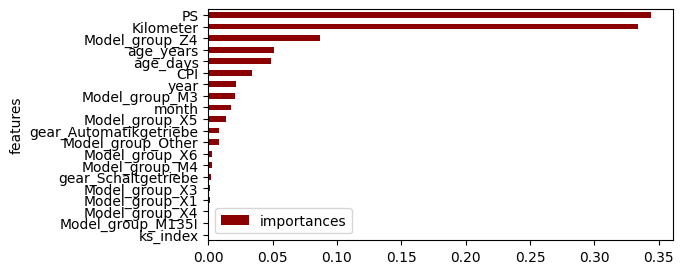

In [11]:
cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred', 
           figsize=(6,3))

### Calculate the residuals

In [12]:
# make predictions
y_train_predict = random_forest_model.predict(X_train)
residuals = y_train - y_train_predict

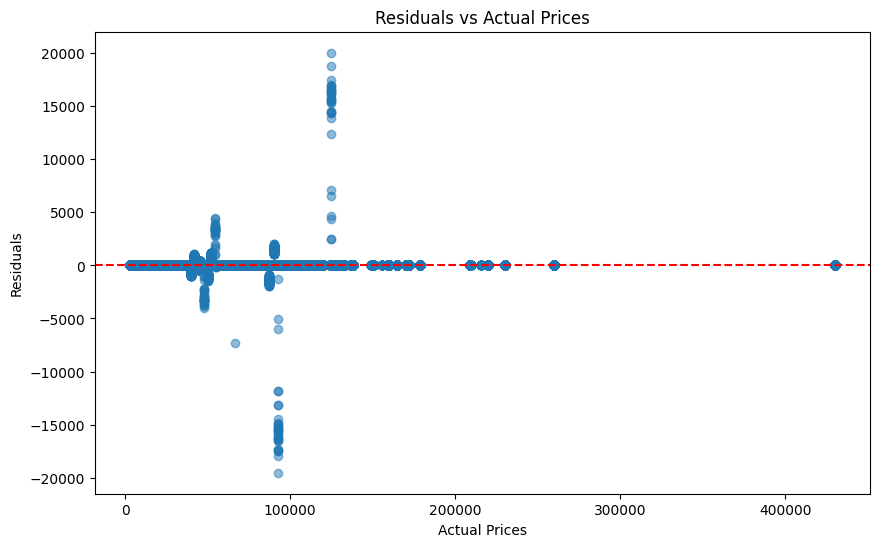

In [13]:
# Calculate residuals

plt.figure(figsize=(10, 6))
plt.scatter(y_train, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Prices')
plt.show()

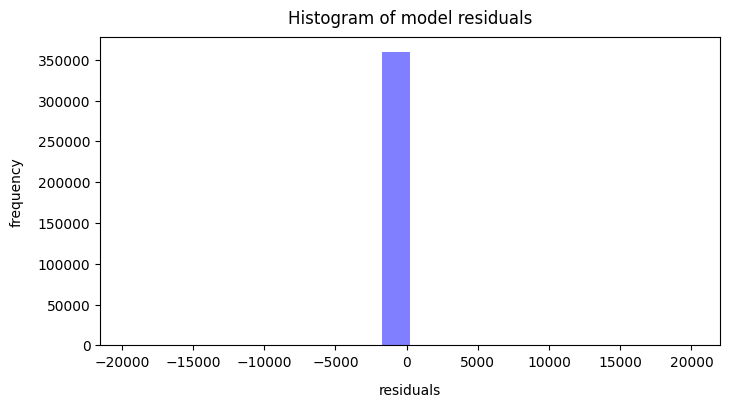

In [14]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=20, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

plt.show()

In [15]:
# Nach dem Fitten deines Baseline-RF
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

final_model = rf


In [16]:
import joblib
joblib.dump(final_model, "model.pkl")


['model.pkl']

In [17]:
import json
json.dump(X.columns.tolist(), open("features.json","w"))
